# Conditional Gaussian Likelihood
Here we go through a simple example of recovering a posterior with SBI. For this, we will use an analytic model, for which we can then compare the result of a fitted and analytic likelihood (and posterior).

 __This example is equivalent to the CMAF Likelihood example, with the difference of using Conditional Gaussian instead.__

## Model
The simple model has two parameteres, $\mu_0$ and $\sigma_0$. Prior distributions are defined as:
$$P(\mu_0) = \frac{1}{2\pi} \exp \left(-\frac{1}{2} \mu_0^2\right)$$
$$P(\log_{10} \sigma_0) = \begin{cases} 1 & \text{for} -1/2 < \log_{10} \sigma_0 < 1/2 \\ 0 & \text{otherwise}\end{cases}$$

We'll work in a 5D data space, where the analytic likelihood is given by:
$$P(\boldsymbol{d} | \mu_0, \sigma_0) = \frac{1}{(2\pi)^{5/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2} (\boldsymbol{d} - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{d} - \boldsymbol{\mu})\right) \, ,$$
where $$\boldsymbol{\mu} = (1^2, 2^2, 3^2, 4^2, 5^2) \cdot \mu_0 \, ,$$
$$\Sigma = 
\begin{pmatrix}
1^2 & 0 & 0 & 0 & 0\\
0 & 2^2 & 0 & 0 & 0\\
0 & 0 & 3^2 & 0 & 0\\
0 & 0 & 0 & 4^2 & 0\\
0 & 0 & 0 & 0 & 5^2
\end{pmatrix} \cdot \sigma^2_0 \, .$$

## Fitting the likelihood
To fit the likelihood we create 100 000 data samples of the likelihood function, for $\mu_0$ and $\sigma_0$ pulled from the prior. In this way, the training set follows the prior distribution. This is not strictly necessary. Because we fit the likelihood, final posterior recovery will be insensitive on how were the training samples constructed. The benefit of using the real prior however, is to allow the network to learn important part of the parameter space.

## Mock measurement
With this at hand, we sample 10 points from the analytic likelihood as our mock measurement, for fixed $\mu_0 = 1$, $\sigma_0 = 1$ and try to recover posterior using the fitted likelihood. The final result is then compared with the posterior recovered from the analytic likelihood.



In [1]:
# setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

from functools import partial
import logging
import corner
import ultranest
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from py21cmlikelihoods import ConditionalGaussian
from py21cmlikelihoods.utils import prepare_dataset

tfd = tfp.distributions
tfb = tfp.bijectors

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ultranest_logger = logging.getLogger("ultranest")
ultranest_logger.addHandler(logging.NullHandler())
ultranest_logger.setLevel(logging.INFO)

2023-05-05 15:06:42.278935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# constructing the likelihood
NDE = ConditionalGaussian(
    n_parameters = 2, 
    n_data = 5, 
    diagonal_covariance = True,
    n_hidden = [50] * 10,
    optimizer = tf.optimizers.Adam(1e-3), 
    kernel_initializer = partial(
        tf.keras.initializers.RandomNormal, mean=0, stddev=1e-5, seed=None
    ),
    final_bias_initializer = "ones",
)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2023-05-05 15:06:48.736677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# constructing the training set
mu_0 = np.random.normal(0.0, 1.0, size = 100000)
sigma_0 = 10 ** np.random.uniform(-0.5, 0.5, size = 100000)
params = np.stack([mu_0, sigma_0], axis = -1)
data = np.array([np.random.multivariate_normal(np.arange(1, 6)**2 * m, np.diag(np.arange(1, 6)**2 * s**2)) for m, s in params])

training_set = prepare_dataset(NDE, data_samples=data, param_samples=params, batch_size=100)

In [4]:
# training the likelihood
NDE.train(
    epochs = 30,
    dataset = training_set,
    pretrain = True,
    pretrain_epochs = 10,
    pretrain_optimizer = tf.optimizers.Adam(1e-3), 
    save = False,
    save_history = False,
    verbose = 1,
)

Epoch 1/10
1000/1000 [==============================] - 5s 3ms/step - loss: 547.7416
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 547.5808
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 547.5836
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 547.5643
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 547.5530
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 547.5641
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 547.5406
Epoch 8/10
1000/1000 [==============================] - 4s 3ms/step - loss: 547.5451
Epoch 9/10
1000/1000 [==============================] - 4s 4ms/step - loss: 547.5457
Epoch 10/10
1000/1000 [==============================] - 4s 4ms/step - loss: 547.5315
Epoch 1/30
1000/1000 [==============================] - 8s 5ms/step - loss: 27.3002
Epoch 2/30
1000/1000 [==============================] - 5s 4ms/st

[ 2.1329544  8.0466585 18.466213  32.77405   51.23101  ] [0.9629376 1.8231858 2.7775755 3.7552476 4.7975593]
[ 2.00675877  8.00548303 17.99817214 31.98528474 50.00466841] [1.00109033 1.99616295 3.003081   4.00014342 5.00564881]


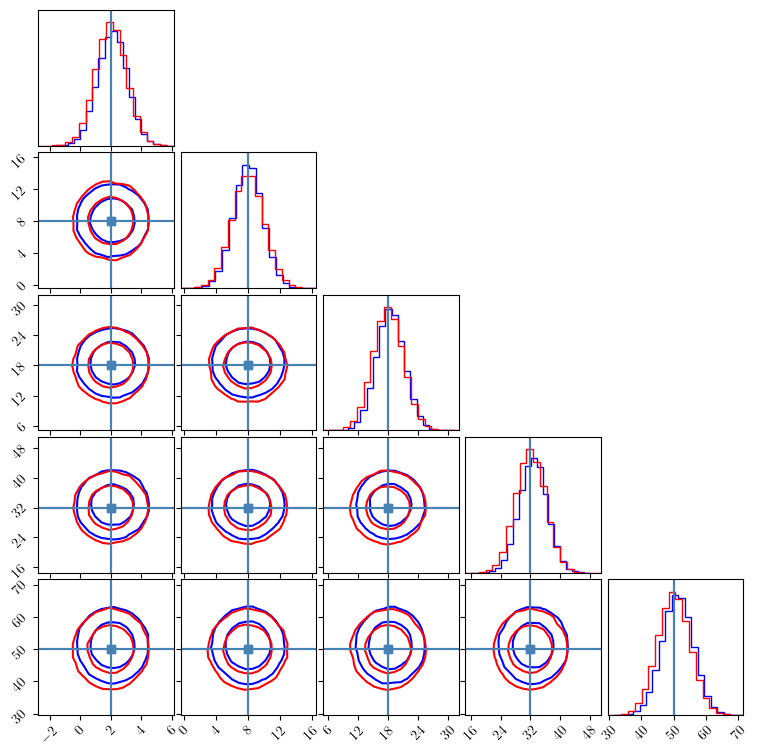

In [5]:
# testing the likelihood shape for mu_0 = 2, sigma_0 = 1
NDE_sample = NDE.sample(100000, conditional = tf.constant([2.0, 1.0])).numpy()
analytic_sample = np.random.multivariate_normal(np.arange(1, 6)**2 * 2, np.diag(np.arange(1, 6)**2), 100000)

fig = plt.figure(figsize = (8, 8))
corner.corner(
    NDE_sample, 
    fig = fig, 
    color = "blue", 
    truths = np.arange(1, 6)**2 * 2, 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
)
corner.corner(
    analytic_sample, 
    fig = fig, 
    color = "red", 
    truths = np.arange(1, 6)**2 * 2, 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
)
print(NDE_sample.mean(axis = 0), NDE_sample.std(axis = 0))
print(analytic_sample.mean(axis = 0), analytic_sample.std(axis = 0))

# Recovering posterior
To recover posterior we use fitted NDE likelihood and analytic likelihood, together with prior specified at the beginning. For sampling, we use `ultranest` nested sampler.

As previously mentioned, for the mock measurement we use 10 i.i.d. samples for $\mu_0 = 1$ and $\sigma_0 = 1$. The hope is that final posterior shifts towards those values.

In [6]:
mock_measurement = np.random.multivariate_normal(np.arange(1, 6)**2, np.diag(np.arange(1, 6)**2), 10)

In [7]:
def log_gauss(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma) - 0.5 * (x - mu)**2 / sigma**2 

def analytic_log_likelihood(d, mu_0, sigma_0):
    mu = (np.arange(1, 6)**2).reshape(1, -1) * mu_0.reshape(-1, 1)
    cov = (np.arange(1, 6)**2).reshape(1, -1) * sigma_0.reshape(-1, 1)**2
    c = -2.5 * np.log(2 * np.pi) - 0.5 * np.log(np.prod(cov, axis = -1))
    l = -0.5 * np.sum((d - mu)**2 / cov, axis = -1)
    return c + l

In [8]:
def ultranest_NDE_likelihood(p):
    likelihood = np.sum(np.array([NDE.log_prob(mock, p).numpy() for mock in mock_measurement]), axis = 0)
    prior = log_gauss(0.0, p[:, 0], p[:, 1])
    return prior + likelihood

def ultranest_analytic_likelihood(p):
    likelihood = np.sum(np.array([analytic_log_likelihood(mock, p[:, 0], p[:, 1]) for mock in mock_measurement]), axis = 0)
    prior = log_gauss(0.0, p[:, 0], p[:, 1])
    return prior + likelihood

def transformation(p):
    x = np.zeros(p.shape, dtype = p.dtype)
    x[:, 0] = -5 + 10 * p[:, 0]
    x[:, 1] = 10 ** (-0.5 + p[:, 1])
    return x

In [9]:
sampler_NDE = ultranest.ReactiveNestedSampler(
    ["mu_0", "sigma_0"], 
    loglike = ultranest_NDE_likelihood, 
    transform = transformation,
    vectorized = True,
    draw_multiple = True,
    ndraw_min = 1000,
    ndraw_max = 100000,
)
result_NDE = sampler_NDE.run(
    min_num_live_points = 1000,
    min_ess = 1000,
)
sampler_NDE.print_results()

Z=-121.4(98.94%) | Like=-114.65..-114.64 [-114.6507..-114.6507]*| it/evals=11300/17611 eff=68.0272% N=1000  
logZ = -121.398 +- 0.137
  single instance: logZ = -121.398 +- 0.076
  bootstrapped   : logZ = -121.379 +- 0.137
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    mu_0                : 0.787 │ ▁▁▁ ▁▁▁▁▁▁▁▂▂▃▅▅▆▇▇▇▇▆▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁ │1.149     0.974 +- 0.039
    sigma_0             : 0.61  │ ▁▁▁▁▁▂▃▅▅▇▇▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁ ▁▁▁   ▁ │1.69      0.97 +- 0.11



In [10]:
sampler_analytic = ultranest.ReactiveNestedSampler(
    ["mu_0", "sigma_0"], 
    loglike = ultranest_analytic_likelihood, 
    transform = transformation,
    vectorized = True,
    draw_multiple = True,
    ndraw_min = 1000,
    ndraw_max = 100000,
)
result_analytic = sampler_analytic.run(
    min_num_live_points = 1000,
    min_ess = 1000,
)
sampler_analytic.print_results()

Z=-121.4(99.00%) | Like=-114.58..-114.57 [-114.5820..-114.5820]*| it/evals=11400/17377 eff=69.6098% N=1000    
logZ = -121.374 +- 0.187
  single instance: logZ = -121.374 +- 0.076
  bootstrapped   : logZ = -121.360 +- 0.187
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    mu_0                : 0.828 │ ▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁ │1.180     1.002 +- 0.039
    sigma_0             : 0.589 │ ▁▁▁▁▁▁▂▃▄▅▇▇▇▇▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁ ▁ ▁ │1.502     0.919 +- 0.093



In [11]:
def cornerplot(results, fig = None, color = None):
    data = np.array(results['weighted_samples']['points'])
    weights = np.array(results['weighted_samples']['weights'])
    cumsumweights = np.cumsum(weights)

    mask = cumsumweights > 1e-4

    fig = corner.corner(
    data[mask, :],
    weights = weights[mask], 
    fig = fig, 
    color = color, 
    truths = [1.0, 1.0], 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
    labels = ["$\mu_0$", "$\sigma_0$"]
)
    return fig

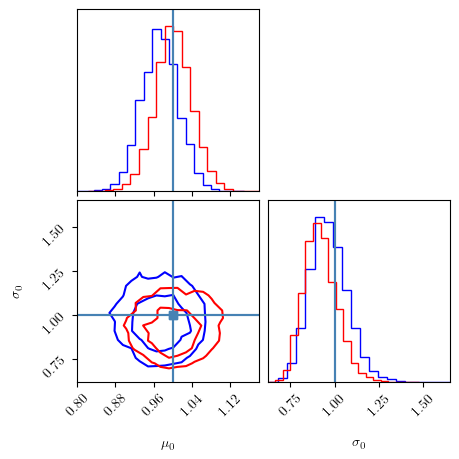

In [12]:
fig = plt.figure(figsize = (5, 5))
fig = cornerplot(result_NDE, fig, "blue")
fig = cornerplot(result_analytic, fig, "red")